# Introduction

This notebook builds two models using the plant pathology dataset with the aim of practicing building a tensorflow classifier in preparation for the tensorflow certification exam. It is part of a series of notebooks and resources contained in this [github repo](https://github.com/nicholasjhana/tensorflow-certification-study-guide).


The plant pathology challenge is to classifiy apple leaves according to their image. Leaves can be classified as "healthy", "multiple diseases", "scab", and "rust". In this notebook we model the multi classification problem using transfer learning. Along the way are short discussions of tensorflow API concepts and how to use them.

## Tensorflow Concepts
This notebook covers the following topics from the tensorflow certification handbook:
- Directory labelling structure for Image Data Generator
- Using Image Data Generator with dataframes
- Using image augmentation with Image Data Generator
- Using learning rate decay
- Using transfer learning and model checkpoints


## Acknowledgements
- [Plant Pathology 2020 : EDA + Models - tarunpaparaju](https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models#Modeling-)
- [Tutorial on using Keras flow_from_directory and generators - Vijayabhaskar J
](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720)
- [How to use .predict_generator() on new Images - Keras](https://stackoverflow.com/questions/52270177/how-to-use-predict-generator-on-new-images-keras/55991598)
- [What Learning Rate Should I Use? - B. D. Hammel](http://www.bdhammel.com/learning-rates/)
- [DenseNet — Dense Convolutional Network - Sik-Ho Tsang](https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803)

## Notebook Contents
- [Balance Data](#balance-data)
- [Image Data Generator](#image-datagen)
    - [Setup](#setup)
    - [Image Augmentation](#image-augmentation)
- [Multi Classification Modelling](#multi-class-model)
    - [Learning rate decay](#learning-rate-decay)
    - [Model checkpoints](#model-checkpoint)
    - [Transfer learning](#transfer-learning)
    - [DenseNet](#densenet)
    - [Making predictions](#making-predictions)

In [ ]:
import os
import shutil
import pandas as pd
import random
import numpy as np

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201

import cv2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")
train_df['img_name'] = train_df['image_id'] + ".jpg"
train_df.head()

In [ ]:
target_multi_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

print("Multi Classification Targets")
print(train_df[target_multi_cols].sum())

<a id="balance-data"></a>
# Balance Dataset

Create a balanced dataset for each of the multi classification targets. This results in an equal number of sampels between the multiple classes.

In [ ]:
def balance_set(df, x_cols, y_cols):
    ros = RandomOverSampler(random_state=42)

    x_multi, y_multi = ros.fit_resample(df[x_cols], df[y_cols].values)
    data = pd.concat([x_multi, pd.DataFrame(y_multi, columns= y_cols)], axis=1)
    return data

train_multi = balance_set(train_df, 
                          x_cols = ["image_id", "img_name"],
                          y_cols = target_multi_cols)


labels = train_multi[target_multi_cols]
label_names = labels[labels==1].stack().reset_index()['level_1']
label_names.index = train_multi.index
train_multi['label_names'] = label_names

print("Multi Classification Labels")
print(train_multi[target_multi_cols].sum())

In [ ]:
# a look at the multi class dataframe
train_multi.head()

<a id="image-datagen"></a>
# Image Data Generator

The Image Data Generator API allows images to be baatch loaded and augmented on the fly. It can be used to return a tf.dataset.Dataset object that uses subdirectories to determin the labels. 

I.e. if sub directories are class_a, and class_b the generator will identify them as class 0 and 1. 

Image data generator contains 3 main methods for sourcing your images:
- *flow()*
- *flow_from_dataframe()*
- *flow_from_directory()*

Each method returns an iterator of tuples (x, y) where x and y are batches of the images, and labels respectively.

<a id="setup"></a>
## Setup

***flow_from_dataframe()*** allows us to read filenames from a dataframe. So we can define the root path, the dataframe, and the columns that contain the file names, and target labels.

***flow_from_directory()*** requires a specific directory setup to work correctly. It will read files directly from the parent directory passed in. Each directory must contain subfolders with the names of the classes. To have a train, valid, and test setup you need to create subdirectories for each class within each. 

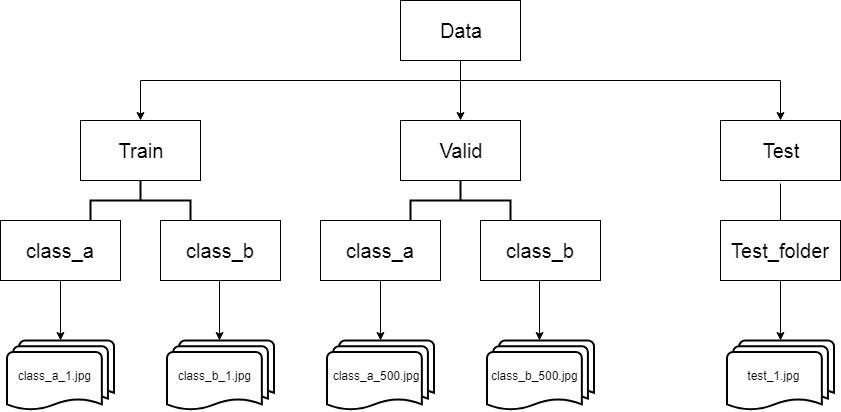

If no subdirectory is present image data generator will not return class labels. This could be desired, for example in the case of the test folder in the above image.

<a id="image-augmentation"></a>
## Augmentation

Image augmentation applies transforms to an image and results in additional images that the network can train on. Image data generator has [many options](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) and also allows custom preprocesing functions through the parameter of the same name.

The images below are augmented with:
- Rotation of up to 180 degrees
- Horizontal Flips
- Verticle Flips
- A preprocessing function adding a small blur to the image

In [ ]:
def blur_preprocessing(img):
    return cv2.blur(img, (5, 5))

tf.random.set_seed(99)

## Initalize Image Data Generator with Augmentation
img_data_generator = ImageDataGenerator(rescale=1/255, 
                                        validation_split=0.2,
                                        rotation_range = 180,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        preprocessing_function=blur_preprocessing
                                       )


## Recreate datasets from dataframe
train_data_multi = img_data_generator.flow_from_dataframe(dataframe=train_multi,
                                                    directory="/kaggle/input/plant-pathology-2020-fgvc7/images/",
                                                    x_col="img_name",
                                                    y_col= "label_names",
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=42)

val_data_multi = img_data_generator.flow_from_dataframe(dataframe=train_multi,
                                                    directory="/kaggle/input/plant-pathology-2020-fgvc7/images/",
                                                    x_col="img_name",
                                                    y_col="label_names",
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='validation',
                                                    shuffle=True,
                                                    seed=42)

Explore some of the images and see how they look.

In [ ]:
def show_imgs(df, num):
    fig, ax = plt.subplots(1,num, figsize=(18,9))
    for x, y in df:
        for img in range(num):
            ax[img].imshow(x[img])
            if y[img][0]:
                title="healthy"
            else:
                title='unhealthy'
            ax[img].set_title(title)
        break
show_imgs(train_data_multi, 5)

<a id="multi-class-model"></a>
# Multi Classification Modelling

<a id="learning-rate-decay"></a>
## Learning Rate Decay
Learning rate decay is a method of changing the learning rate with the number of epochs. The technique is used as a form of regularization and to fine tune a model bringing it closer to the local minimum.

Intuitively learning rate decay means smaller steps along the gadient towards the local minima. So the longer we train, the lower the learning rate will be.  Initally we take large steps along the gradient we find we could result in a situation like the "high learning rate" graph below. Learning rate decay prevents this by reducing the learning rate gradually, with the effect of taking smaller steps and more likely to find the minimum. The drawback is that reducing the learning rate too quick and we could end up similar to the graph "learning rate too low". The following article from [Machine Learning Mastery](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/#:~:text=The%20way%20in%20which%20the,value%20to%20a%20small%20value.) is a good reference.

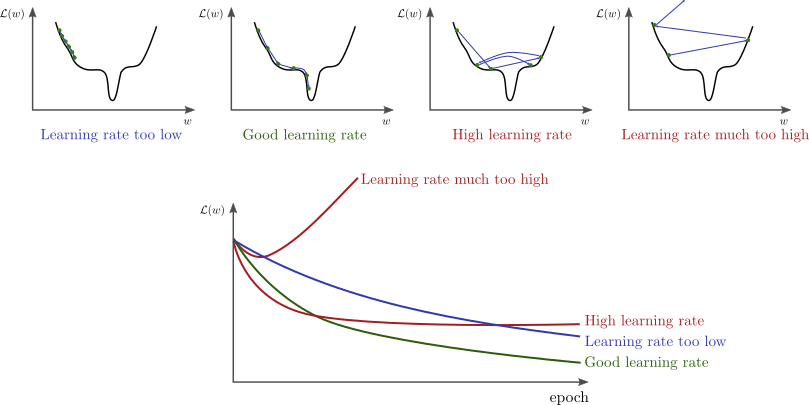

Source: [bdhammel.com](http://www.bdhammel.com/learning-rates/)

### Types of Learning Rate Decay in Tensorflow
We can control the learning rate with the module tf.keras.optimizers.schedules with the following types of decay [Tensorflow Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules).
- ExponentialDecay: A LearningRateSchedule that uses an exponential decay schedule.
- InverseTimeDecay: A LearningRateSchedule that uses an inverse time decay schedule.
- LearningRateSchedule: A serializable learning rate decay schedule.
- PiecewiseConstantDecay: A LearningRateSchedule that uses a piecewise constant decay schedule.
- PolynomialDecay: A LearningRateSchedule that uses a polynomial decay schedule.



In [ ]:
# learning rate decay
learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0003, 
                                                                         decay_steps=2, 
                                                                         decay_rate=0.97, 
                                                                         staircase=False)

<a id="model-checkpoint"></a>
## Model Checkpoints
Model Checkpoints are a call mack technique that allows us to save the model or weights at a given frequency. This allows us to:
1. Start and stop the model at arbitary points in the training process.
2. Track and log the progression of the weights. If `save_best_only=True` this will only save the weights/models with the best performance.
3. Roll back a model to a specific point in trianing. I.e. if performance becomes poor we can modify the network, reload the weights and start again.

Model checkpoints are implmented with the `tf.keras.callbacks.ModelCheckpoint`. [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [ ]:
try:
    os.mkdir("../tmp")
except:
    print("Directory /tmp already exists")

checkpoint = tf.keras.callbacks.ModelCheckpoint("../tmp/multi_class_weights_1", 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=False,
                                                save_weights_only=True, 
                                                period=1)




In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        self.patience = 3
        self.best = 0
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        if np.greater(logs["val_accuracy"], self.best):
            self.wait = 0
            self.best = logs["val_accuracy"]
        else:
            self.wait +=1
            if self.wait >= self.patience:
                print(f"Stopping Training. Validation accuracy hasn't improved >= {self.patience} times")
                self.model.stop_training=True

<a id="transfer-learning"></a>
## Transfer learning
Transfer learning is the practice of using a model, and weights that was trained on a differnt task and applying it to a new task. The idea is to take advantage of what the model learned on the original task and to "transfer" this to the current task.

This is achieved by reusing part of the original model's architechre and only changing the last few layers - typically the dense layers. In the diagram below we see a generic network with a generic task. This could be something like ImageNet that was trained on 1000+ objects. But we're just interested in a few classes, so we reuse the trained weights early in the model. The result is the second network, where we use a specific dataset, for a specific task. 

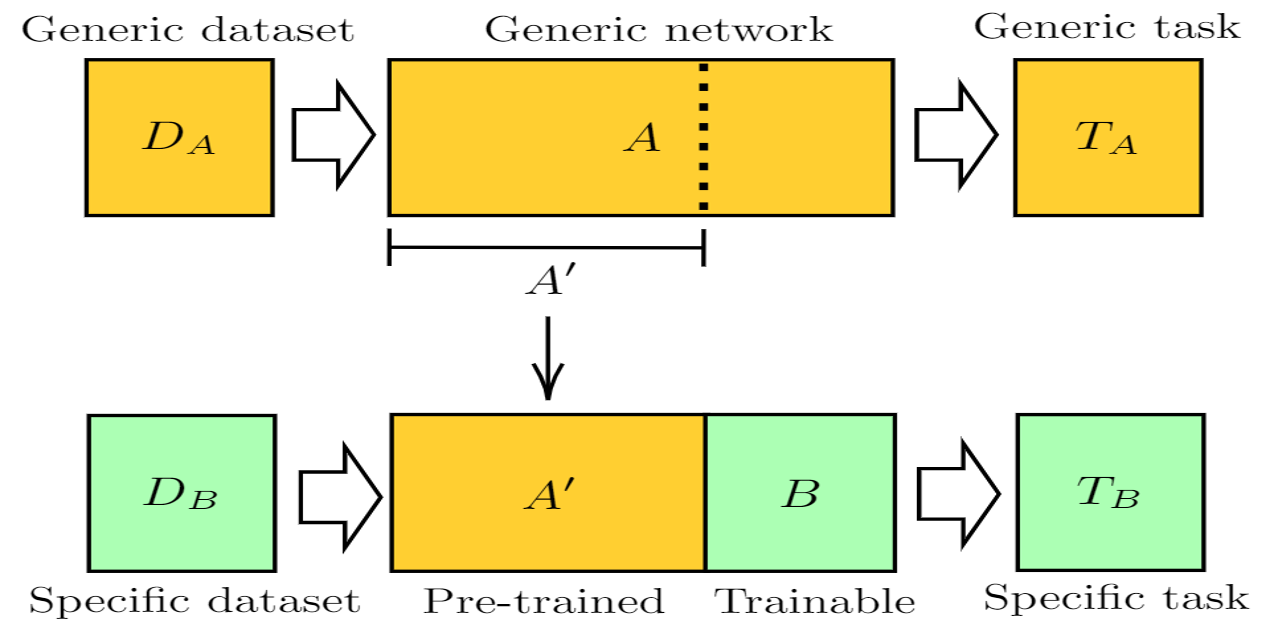
Source: [Open Journal For Quantam Science](https://quantum-journal.org/papers/q-2020-10-09-340/)

There are several advantages of using transfer learning:
1. Leverage learned weights on much larger datasets and the ability to fine tune the weights. Using the `layer.trainable = False` we can control if a layer's weights will be trained or not. For some tasks it might be advantageous to allow some of the weights in early layers to train and in doing so, fine tune for the specific task. 
2. Need for a much smaller dataset. Training an accurate model from scratch can require 10X, 100X times the numbers of samples needed to generalize the network for the task.




<a id="densenet"></a>
## DenseNet

DenseNet is the successor of ResNet and is distinguished as having fewer parameters and higher accuracy. It achieves this by connecting additional inputs from all previous layers into the feature maps of the current layer. As described in [this great article on DenseNet](https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803): "each layer is receiving a collective knowlege from all preceeding layers".

Two advantages of DenseNet's architecture makes it ideal for using transferlearning for the Multi Classification task here:
1. Diversity of features in convolution maps - useful for detecting small detailed features for example.
2. Maintaining low complexitiy features - useful for detecting obvious defects in the leaf.


We use the `tf.keras.applications.DenseNet201` implementation of DenseNet with the 'imagenet' weights.

In [ ]:
def dense_net_model(trainable_weights=False, weights_path=None):
    
    tf.keras.backend.clear_session()
    
    dense_net = DenseNet201(input_shape=(256, 256, 3), weights="imagenet", include_top=False)
    
    for layer in dense_net.layers:
        layer.trainable=trainable_weights
    
    model = tf.keras.models.Sequential([dense_net,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(4, activation='softmax')
                                ])
    
    if weights_path:
        model.load_weights(weights_path)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return model

dense_net_transfer = dense_net_model(trainable_weights=True)

dense_net_transfer_history = dense_net_transfer.fit(train_data_multi, validation_data=val_data_multi, epochs=25, steps_per_epoch=32, callbacks=[checkpoint, EarlyStoppingCallback()])

In [ ]:
#plot loss and accuracy helper function
def plot_loss_accuracy(history):
    fig, axs = plt.subplots(1,2, figsize=(12, 5))

    hist = history.history

    for ax, metric in zip(axs, ["loss", "accuracy"]):
        ax.plot(hist[metric])
        ax.plot(hist["val_"+metric])
        ax.legend([metric, "val_" + metric])
        ax.set_title(metric)

plot_loss_accuracy(dense_net_transfer_history)

<a id="making-predictions"></a>
## Making Predictions

`ImageDataGenerator` can also be used to create predictions in a similar way as when we trained the model with the `.flow_from_dataframe` method. However to predict we don't need to define a y_col. The reset method is called on the data generator to reset the batch starting point after inference.

In [ ]:
test_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")
test_df['img_name'] = test_df['image_id'] + ".jpg"

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory="/kaggle/input/plant-pathology-2020-fgvc7/images/",
                                                  x_col="img_name",
                                                  y_col=None,
                                                  target_size=(256, 256),
                                                  class_mode=None,
                                                  batch_size=3,
                                                  shuffle=False,
                                                  seed=42)

test_generator.reset()

In [ ]:

preds = dense_net_transfer.predict_generator(test_generator, verbose=1, steps=607)

preds_df = pd.DataFrame(preds, columns=["healthy", "multiple_diseases", "rust", "scab"])

submission = pd.concat([test_df.image_id, preds_df], axis=1)

submission.head()

In [ ]:
submission.to_csv("submission_DenseNet.csv", index=False)